In [18]:
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Optional
import random

@dataclass
class Soldier:
    """Represents a single soldier on the battlefield."""
    x: float
    y: float
    strength: int  # 1, 2, 3 (low, medium, high)
    health: int    # 1, 2, 3 (low, medium, high)
    unit_type: str  # 'soldier', 'knight', 'archer'
    team: str  # 'Quantum' or 'Classical'
    range_dist: int  # 1, 2, 3 (low, medium, high)
    max_health: int = None  # Track original health for display

    def __post_init__(self):
        """Store max health after initialization."""
        if self.max_health is None:
            self.max_health = self.health

    def distance_to(self, other: 'Soldier') -> float:
        """Manhattan distance to another soldier."""
        return abs(self.x - other.x) + abs(self.y - other.y)

    def can_fight(self, other: 'Soldier') -> bool:
        """Check if this soldier can fight another."""
        return self.team != other.team and self.distance_to(other) <= self.range_dist

    def is_alive(self) -> bool:
        """Check if soldier is still alive."""
        return self.health >= 1

    def take_damage(self, damage: int):
        """Reduce health by damage amount. Health stays between 0 and 3."""
        self.health = max(0, min(3, self.health - damage))

    def attack(self, other: 'Soldier') -> int:
        """
        Attack another soldier and return damage dealt.
        Damage is based on strength (1, 2, or 3).
        Soldiers die when health drops below 1.
        """
        if not self.can_fight(other):
            return 0
        # Damage equals attacker's strength
        damage = self.strength
        other.take_damage(damage)
        return damage

class QuantumBattlefield:
    """Manages the battle simulation."""
    def __init__(self, width: int = 4, height: int = 4):
        self.width = width
        self.height = height
        self.board_size = width * height
        self.soldiers: List[Soldier] = []
        self.turn = 0
        self.history = {'team_a_count': [], 'team_b_count': [], 'turn': []}

    def add_soldier(self, soldier: Soldier):
        """Add a soldier to the battlefield."""
        self.soldiers.append(soldier)

    def initialize_team(self, team: str, composition: dict, start_x_range: Tuple[int, int]):
        """
        Initialize a team with given composition.

        Args:
            team: 'Quantum' or 'Classical'
            composition: {'unit_type': (count, strength, health, range_dist)}
            start_x_range: (x_min, x_max) for starting positions (inclusive)
        """
        # All possible x positions in the allowed range
        xs = range(start_x_range[0], start_x_range[1] + 1)
        ys = range(self.height)

        # Create a list of all (x, y) pairs
        all_positions = [(x, y) for x in xs for y in ys]
        random.shuffle(all_positions)
        pos_index = 0

        for unit_type, (count, strength, health, range_dist) in composition.items():
            for _ in range(count):
                if pos_index >= len(all_positions):
                    print(f"Warning: Not enough positions for all units!")
                    break

                x, y = all_positions[pos_index]
                pos_index += 1

                soldier = Soldier(x, y, strength, health, unit_type, team, range_dist)
                self.add_soldier(soldier)

    def record_history(self):
        """Record current soldier counts for this turn."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'B')
        self.history['team_a_count'].append(count_a)
        self.history['team_b_count'].append(count_b)
        self.history['turn'].append(self.turn)

    def move_soldiers(self):
        for soldier in self.soldiers:
            if not soldier.is_alive():
                continue
            if soldier.team == "Quantum":
                # take the best posible move
                # the function must return a tuple best_move = (x,y) based on the current position of the soldier
                # it can accept any desired extra argument
                best_move = (random.randint(-1, 1), random.randint(-1, 1))
            else:
                # the classical team moves using random walks
                best_move = (random.randint(-1, 1), random.randint(-1, 1))

            # clip to the grid
            new_x = max(0, min(self.width - 1, best_move[0]))
            new_y = max(0, min(self.height - 1, best_move[1]))
            # update position
            if not self._is_position_occupied_by_teammate(new_x, new_y, soldier):
                # Update position only if not occupied by teammate
                soldier.x, soldier.y = new_x, new_y

    def _find_nearest_enemy(self, soldier: Soldier) -> Optional[Soldier]:
        """Find the nearest enemy soldier."""
        enemies = [s for s in self.soldiers if s.team != soldier.team and s.is_alive()]
        if not enemies:
            return None
        return min(enemies, key=lambda e: soldier.distance_to(e))

    def _is_position_occupied_by_teammate(self, x: float, y: float, soldier: Soldier) -> bool:
        """Check if a position is occupied by a teammate."""
        for other in self.soldiers:
            if other is not soldier and other.is_alive() and other.team == soldier.team:
                if other.x == x and other.y == y:
                    return True
        return False

    def resolve_combat(self):
        """
        Resolve all combats this turn.
        Each soldier attacks enemies in range based on their strength.
        Soldiers die when health reaches 0.
        """
        combat_pairs = []

        # Find all valid combat pairs
        for i, attacker in enumerate(self.soldiers):
            if not attacker.is_alive():
                continue

            # Find enemies in range
            targets = [s for s in self.soldiers if attacker.can_fight(s) and s.is_alive()]

            if targets:
                # Attack the weakest enemy in range (lowest current health)
                target = min(targets, key=lambda s: s.health)
                combat_pairs.append((attacker, target))

        # Execute all attacks
        for attacker, defender in combat_pairs:
            if attacker.is_alive() and defender.is_alive():
                attacker.attack(defender)

        # Remove dead soldiers
        self.soldiers = [s for s in self.soldiers if s.is_alive()]

    def step(self):
        """Execute one turn of the battle."""
        self.move_soldiers()
        self.resolve_combat()
        self.turn += 1
        self.record_history()

    def is_battle_over(self) -> bool:
        """Check if battle has ended."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'Classical')
        return count_a == 0 or count_b == 0

    def get_winner(self) -> str:
        """Return 'Quantum', 'Classical', or None."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'Classical')
        if count_a == 0 and count_b == 0:
            return None
        if count_a == 0:
            return 'Classical'
        if count_b == 0:
            return 'Quantum'
        return None

    def get_survivor_count(self) -> Tuple[int, int]:
        """Return (team_a_survivors, team_b_survivors)."""
        count_a = sum(1 for s in self.soldiers if s.team == 'Quantum')
        count_b = sum(1 for s in self.soldiers if s.team == 'Classical')
        return count_a, count_b

def visualize_battle(battlefield: QuantumBattlefield, save_path: str = None):
    """Create a static visualization of the battlefield with unit types as markers."""
    fig, ax = plt.subplots()

    # Define markers for unit types
    markers = {'soldier': 'o', 'knight': 's', 'archer': '^'}
    colors = {'Quantum': 'royalblue', 'Classical': 'firebrick'}

    # Plot each combination of team and unit type
    for team in ['Quantum', 'Classical']:
        for unit_type, marker in markers.items():
            soldiers = [s for s in battlefield.soldiers
                       if s.team == team and s.unit_type == unit_type]
            if soldiers:
                ax.scatter([s.x for s in soldiers], [s.y for s in soldiers],
                          c=colors[team], marker=marker, s=100, alpha=0.7,
                          label=f'Team {team} - {unit_type}', edgecolors='black', linewidth=0.5)

    ax.set_xlim(-0.1, battlefield.width - 1  + 0.1)
    ax.set_xticks([x for x in range(battlefield.width)])
    ax.set_xticklabels([])
    ax.set_ylim(-0.1, battlefield.height - 1 + 0.1)
    ax.set_yticks([x for x in range(battlefield.height)])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.tick_params(axis='both', direction='in')
    ax.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
    plt.show()

def plot_history(battlefield: QuantumBattlefield, save_path: str = None):
    """Plot team sizes over time."""
    plt.figure()
    plt.plot(battlefield.history['turn'], battlefield.history['team_a_count'],
             label='Team Quantum', color='royalblue', linewidth=2)
    plt.plot(battlefield.history['turn'], battlefield.history['team_b_count'],
             label='Team Firebrick', color='firebrick', linewidth=2)
    plt.xlabel('Turn')
    plt.xticks(battlefield.history['turn'])
    plt.ylabel('Soldier Count')
    plt.title('Team Size Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path)
    plt.show()

Ganador: Classical


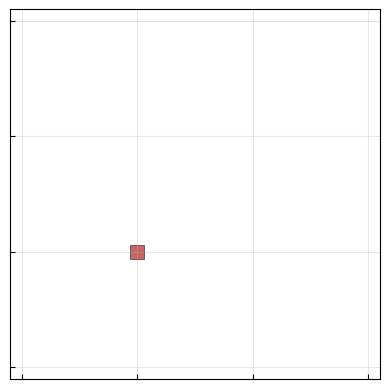

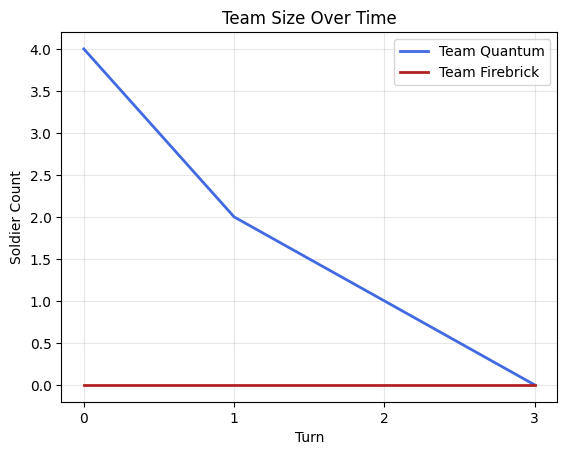

In [39]:
# 1. Crear el campo de batalla
battlefield = QuantumBattlefield(width=4, height=4)

# 2. Definir la composición de cada equipo
quantum_composition = {
    'soldier': (2, 1, 2, 1),   # 2 soldados débiles
    'knight':  (1, 3, 3, 1),   # 1 caballero fuerte
    'archer':  (1, 2, 1, 3)    # 1 arquero largo alcance
}

#count, stregnth, helath, range

classical_composition = {
    'soldier': (2, 1, 2, 1),
    'knight':  (1, 3, 3, 1),
    'archer':  (1, 2, 1, 3)
}

# 3. Inicializar equipos en lados opuestos del tablero
battlefield.initialize_team(
    team='Quantum',
    composition=quantum_composition,
    start_x_range=(0, 1)   # lado izquierdo
)

battlefield.initialize_team(
    team='Classical',
    composition=classical_composition,
    start_x_range=(2, 3)   # lado derecho
)

# 4. Guardar estado inicial
battlefield.record_history()

# 5. Ejecutar la batalla
max_turns = 20

while not battlefield.is_battle_over() and battlefield.turn < max_turns:
    battlefield.step()

# 6. Mostrar ganador
winner = battlefield.get_winner()
print("Ganador:", winner)

# 7. Visualizar resultados
visualize_battle(battlefield)
plot_history(battlefield)